In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-dataset/breast-cancer.csv


**Import libraries**

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SVMSMOTE
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import linear_model
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**directly model implementation**

Original Training Dataset Size:
X_train shape: (455, 30)
y_train shape: (455,)

Original Testing Dataset Size:
X_test shape: (114, 30)
y_test shape: (114,)
train:  1.0
test:  0.9824561403508771
Confusion matrix


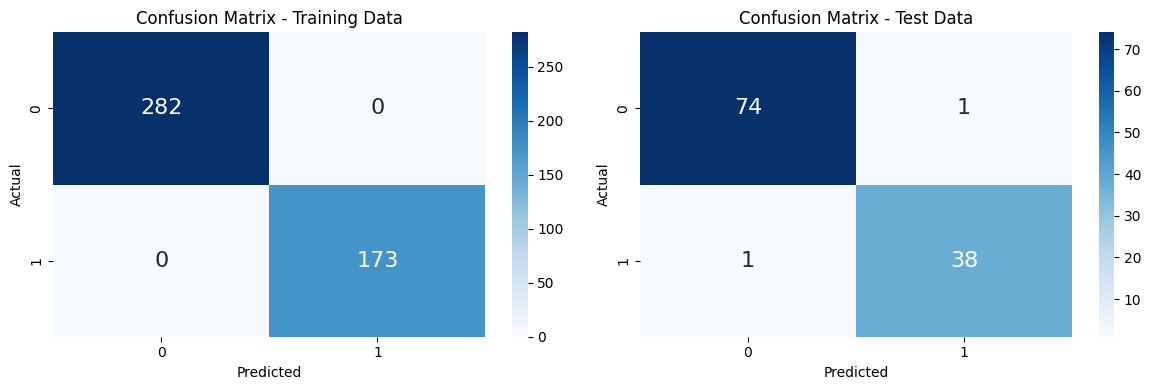

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

dataset = pd.read_csv("../input/breast-cancer-dataset/breast-cancer.csv")

X = dataset.iloc[:,2:]
y = dataset.iloc[:,1]
y = pd.get_dummies(y)
y = y.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


# Print Training dataset size
print("Original Training Dataset Size:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print()


# Print Testing dataset size
print("Original Testing Dataset Size:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X_train, y_train)
train_score=clf.score(X_train, y_train)
test_score=clf.score(X_test, y_test)
print("train: ",train_score)
print("test: " , test_score)


print("Confusion matrix")

# Predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


**GAN**

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.ensemble import AdaBoostClassifier

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define the GAN
class GAN:
    def __init__(self, latent_dim, lr):
        self.latent_dim = latent_dim
        self.lr = lr
        self.generator = Generator(latent_dim, X_train.shape[1])
        self.discriminator = Discriminator(X_train.shape[1])
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator.to(self.device)
        self.discriminator.to(self.device)
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr)
        self.criterion = nn.BCELoss()

    def generate_samples(self, num_samples):
        noise = torch.randn(num_samples, self.latent_dim).to(self.device)
        generated_samples = self.generator(noise)
        return generated_samples.cpu().detach().numpy()
   
    def train_gan(self, X_real, y_real, epochs, batch_size):
        for epoch in range(epochs):
            for batch_idx in range(0, len(X_real), batch_size):
                real_samples = torch.from_numpy(X_real[batch_idx:batch_idx + batch_size]).float().to(self.device)
                real_labels = torch.from_numpy(y_real[batch_idx:batch_idx + batch_size]).float().to(self.device).view(-1, 1)

                # Training the discriminator
                self.discriminator_optimizer.zero_grad()
                d_real_output = self.discriminator(real_samples)
                d_real_loss = self.criterion(d_real_output, real_labels)

                fake_samples = self.generate_samples(len(real_samples))
                fake_labels = torch.randint(0, 2, (len(real_samples), 1)).float().to(self.device)  # Random labels

                d_fake_output = self.discriminator(torch.tensor(fake_samples).float().to(self.device))
                d_fake_loss = self.criterion(d_fake_output, fake_labels)

                d_loss = d_real_loss + d_fake_loss
                d_loss.backward()
                self.discriminator_optimizer.step()

                # Training the generator
                self.generator_optimizer.zero_grad()
                noise = torch.randn(len(real_samples), self.latent_dim).to(self.device)
                generated_samples = self.generator(noise)

                # Use real labels for positive examples
                g_labels = torch.from_numpy(y_real[batch_idx:batch_idx + batch_size]).float().to(self.device).view(-1, 1)

                g_fake_output = self.discriminator(generated_samples)
                g_loss = self.criterion(g_fake_output, g_labels)

                g_loss.backward()
                self.generator_optimizer.step()


    def fit_resample(self, X_real, y_real, num_samples):
        self.train_gan(X_real, y_real.values, epochs=100, batch_size=32)
        synthetic_samples = self.generate_samples(num_samples)

        # Use the discriminator to predict labels for synthetic samples
        synthetic_labels = self.discriminator(torch.tensor(synthetic_samples).float().to(self.device)).cpu().detach().numpy()

        # Print counts and ratios in the resampled dataset
        print("\nResampled Dataset:")
        print("Number of 1s in y_resampled:", np.sum(synthetic_labels))
        print("Number of 0s in y_resampled:", len(synthetic_labels) - np.sum(synthetic_labels))
        print("Ratio of 1s in y_resampled:", np.sum(synthetic_labels) / len(synthetic_labels))

        # Adjust threshold and print counts again
        threshold = 0.5
        binary_synthetic_labels = (synthetic_labels > threshold).astype(int)
        print("\nAfter Adjusting Threshold:")
        print("Number of 1s in y_resampled:", np.sum(binary_synthetic_labels))
        print("Number of 0s in y_resampled:", len(binary_synthetic_labels) - np.sum(binary_synthetic_labels))
        print("Ratio of 1s in y_resampled:", np.sum(binary_synthetic_labels) / len(binary_synthetic_labels))

        # Ensure y_real is a NumPy array
        y_real_np = y_real.values.reshape(-1, 1)

        # Concatenate along the correct axis
        return np.concatenate([X_real, synthetic_samples]), np.concatenate([y_real_np, binary_synthetic_labels])





Resampled Dataset:
Number of 1s in y_resampled: 136.99121
Number of 0s in y_resampled: 145.0087890625
Ratio of 1s in y_resampled: 0.48578443594858156

After Adjusting Threshold:
Number of 1s in y_resampled: 14
Number of 0s in y_resampled: 268
Ratio of 1s in y_resampled: 0.04964539007092199

Dataset Size with GAN:
X_resampled shape: (737, 30)
y_resampled shape: (737, 1)

Original Testing Dataset Size:
X_test shape: (114, 30)
y_test shape: (114,)



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train:  1.0
test:  0.9824561403508771
Confusion matrix


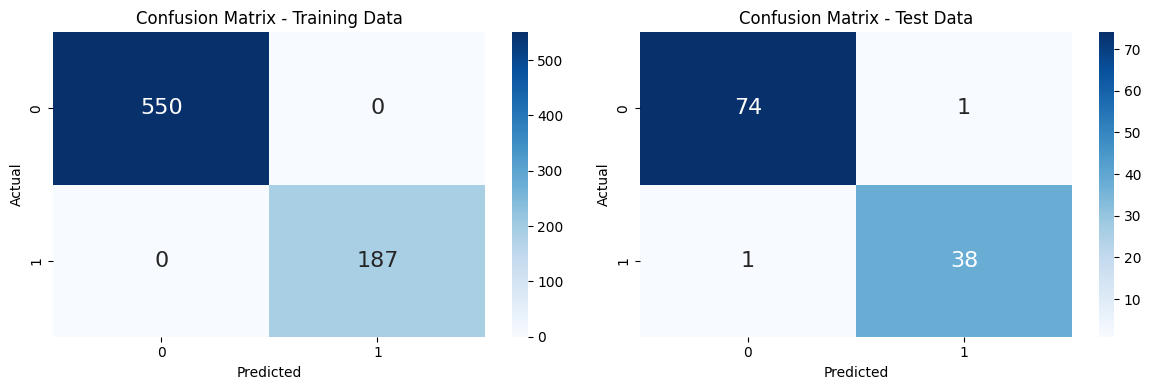

[[-2.75186755e-01 -1.38005864e-01 -2.48644807e-01 ...  1.44737061e+00
   1.61104623e+00  2.01475765e+00]
 [-1.23837994e-01 -3.87707703e-01 -1.74846120e-01 ... -3.67628667e-01
  -6.22670647e-01 -8.14411747e-01]
 [-9.77673457e-01  2.85508038e-01 -9.31904560e-01 ... -4.40979057e-01
  -4.82053159e-01  2.05377886e-01]
 ...
 [ 3.82091920e-03  2.85256375e-03  2.16013473e-03 ...  2.42962851e-03
   2.70393933e-03  1.11579467e-02]
 [ 7.67256599e-04  1.26093603e-03  1.93567562e-03 ...  1.85093074e-03
   4.46064677e-03  1.10528218e-02]
 [ 2.30041984e-03  8.13108985e-04  2.25072587e-03 ...  1.13108859e-03
   1.24398514e-03  1.36282118e-02]]
dekhte hai:(


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train:  0.9172320217096337
test:  0.9035087719298246


In [7]:
# Create GAN and balance the dataset
gan = GAN(latent_dim=100, lr=0.0002)
X_resampled, y_resampled = gan.fit_resample(X_train, y_train, num_samples=len(X_train) - sum(y_train))

# Print dataset size after applying GAN
print("\nDataset Size with GAN:")
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

# ... (remaining code)

print()

# Print Testing dataset size
print("Original Testing Dataset Size:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print()

clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X_resampled, y_resampled)
train_score = clf.score(X_resampled, y_resampled)
test_score = clf.score(X_test, y_test)
print("train: ", train_score)
print("test: ", test_score)

print("Confusion matrix")

# Predictions
y_pred_train = clf.predict(X_resampled)
y_pred_test = clf.predict(X_test)

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_resampled, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


print(X_resampled)
print("dekhte hai:(")

clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X_resampled[455:], y_resampled[455:])

# Evaluate on the entire resampled dataset and the test set
train_score = clf.score(X_resampled, y_resampled)
test_score = clf.score(X_test, y_test)

print("train: ", train_score)
print("test: ", test_score)

Confusion matrix


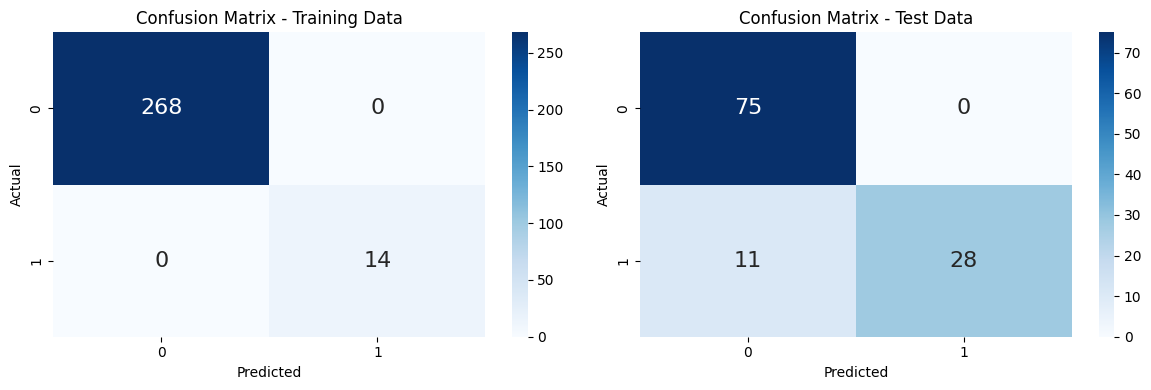

In [8]:
print("Confusion matrix")

# Predictions
y_pred_train = clf.predict(X_resampled[455:])
y_pred_test = clf.predict(X_test)

# Confusion Matrix
conf_matrix_train = confusion_matrix(y_resampled[455:], y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [26]:
print(type(X_resampled))
print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)


<class 'numpy.ndarray'>
Shape of X_resampled: (737, 30)
Shape of y_resampled: (737, 1)


/tmp/ipykernel_47/4293691320.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train[indices, 0], X_train[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')
/tmp/ipykernel_47/4293691320.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_resampled[indices, 0], X_resampled[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')
/tmp/ipykernel_47/4293691320.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_resampled_after_444[indices, 0], X_resampled_after_444[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')


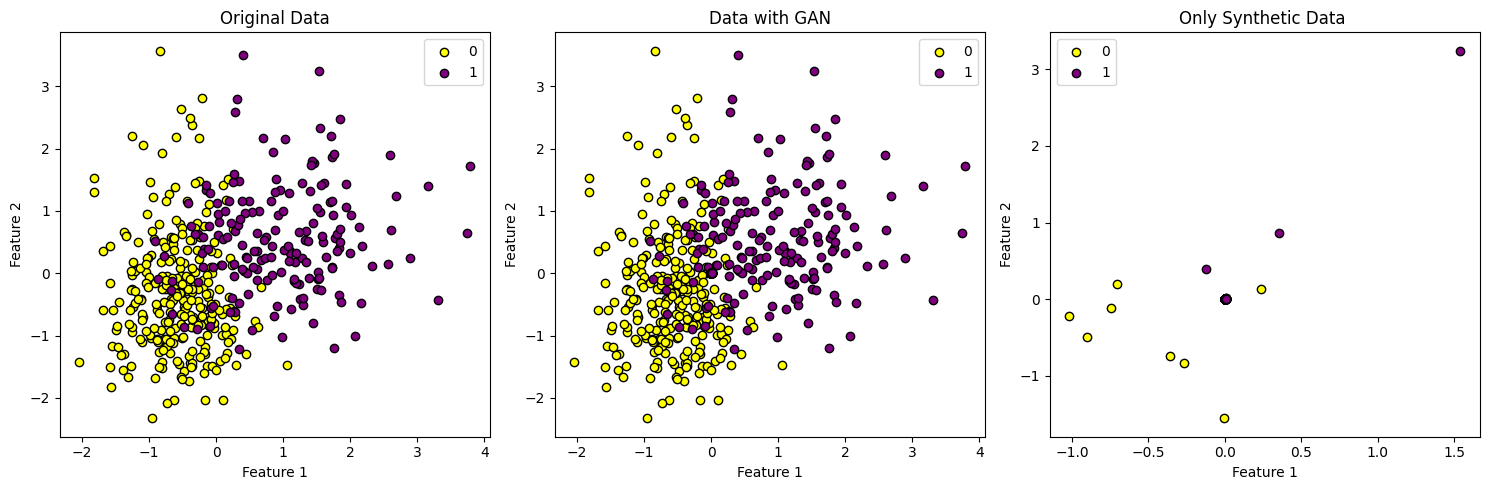

Shape of X_resampled_after_444: (293, 30)


In [32]:
import matplotlib.pyplot as plt

# Define colors for the classes
colors = {0: 'yellow', 1: 'purple'}

# Plot the original data, GAN-generated data, and only synthetic data
plt.figure(figsize=(15, 5))

# Plot 1: Original Data
plt.subplot(1, 3, 1)
for label, color in colors.items():
    indices = (y_train == label)
    plt.scatter(X_train[indices, 0], X_train[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# # Plot 2: Data with GAN
# plt.subplot(1, 3, 2)
# for label, color in colors.items():
#     indices = (y_resampled == label)
#     plt.scatter(X_resampled[indices, 0], X_resampled[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')
# plt.title('Data with GAN')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()

# Plot 2: Data with GAN
# Flatten y_resampled
y_resampled_flat = y_resampled.flatten()

# Plot 2: Data with GAN
plt.subplot(1, 3, 2)
for label, color in colors.items():
    indices = (y_resampled_flat == label)
    plt.scatter(X_resampled[indices, 0], X_resampled[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')
plt.title('Data with GAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()





# # Plot 3: Only Synthetic Data
# Consider values after index 444
X_resampled_after_444 = X_resampled[444:]
y_resampled_after_444_flat = y_resampled[444:].flatten()

# Plot 3: Only Synthetic Data after index 444
plt.subplot(1, 3, 3)
for label, color in colors.items():
    indices = (y_resampled_after_444_flat == label)
    plt.scatter(X_resampled_after_444[indices, 0], X_resampled_after_444[indices, 1], c=color, label=str(label), cmap='viridis', edgecolor='k')
plt.title('Only Synthetic Data ')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()


plt.tight_layout()
plt.show()
print("Shape of X_resampled_after_444:", X_resampled_after_444.shape)

In [35]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=26cab9c91867850e13be17d1f321b56d383ed1f936f60f402c22ab028a756052
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [36]:
import torch
from torchviz import make_dot

# Assuming you have already created and trained the GAN
gan = GAN(latent_dim=100, lr=0.0002)

# Convert Pandas Series to NumPy array
X_train_np = X_train
y_train_np = y_train.values

# Train the GAN
gan.train_gan(X_train_np, y_train_np, epochs=100, batch_size=32)

# Create dummy input tensors for visualization
dummy_generator_input = torch.randn(1, gan.latent_dim).to(gan.device)
dummy_discriminator_input = torch.randn(30, gan.discriminator.model[0].in_features).to(gan.device)

# Visualize the Generator
generator_output = gan.generator(dummy_generator_input)
generator_dot = make_dot(generator_output, params=dict(gan.generator.named_parameters()))
generator_dot.render("generator_model", format="png")

# Visualize the Discriminator
discriminator_output = gan.discriminator(dummy_discriminator_input)
discriminator_dot = make_dot(discriminator_output, params=dict(gan.discriminator.named_parameters()))
discriminator_dot.render("discriminator_model", format="png")


'discriminator_model.png'

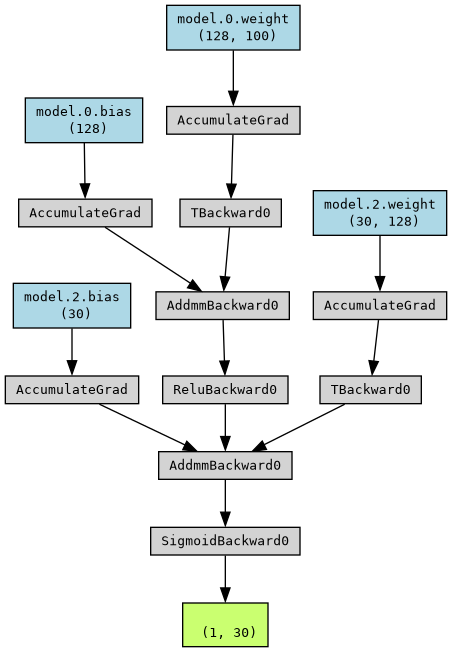

In [37]:
from IPython.display import Image

# Display the Generator model visualization
Image(filename="generator_model.png")


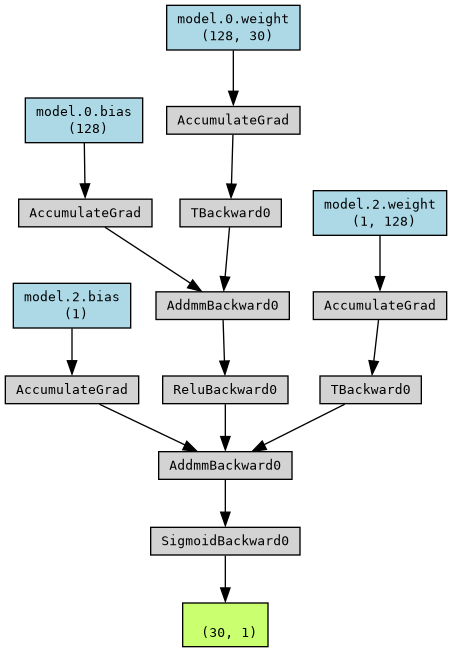

In [38]:
# Display the Discriminator model visualization
Image(filename="discriminator_model.png")
